# **Projeto de Predição de Vitória: League of Legends (Ranked Matches)**
## **Objetivo do Projeto**
**Este projeto visa desenvolver um modelo de classificação capaz de prever o resultado final de uma partida de League of Legends (vitória ou derrota do time azul) com base em dados coletados nos primeiros 10 minutos de jogo.**

**Através da análise de métricas como controle de objetivos, diferença de ouro e abates, o foco é identificar quais fatores são estatisticamente determinantes para o sucesso de uma equipe, fornecendo insights valiosos para a equipe técnica da Riot Games sobre o equilíbrio e a dinâmica competitiva do jogo.**

## **Carregamento e Exploração dos Dados**
Importação das bibliotecas essenciais e leitura do dataset para entender a distribuição das variáveis e verificar a integridade dos dados.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

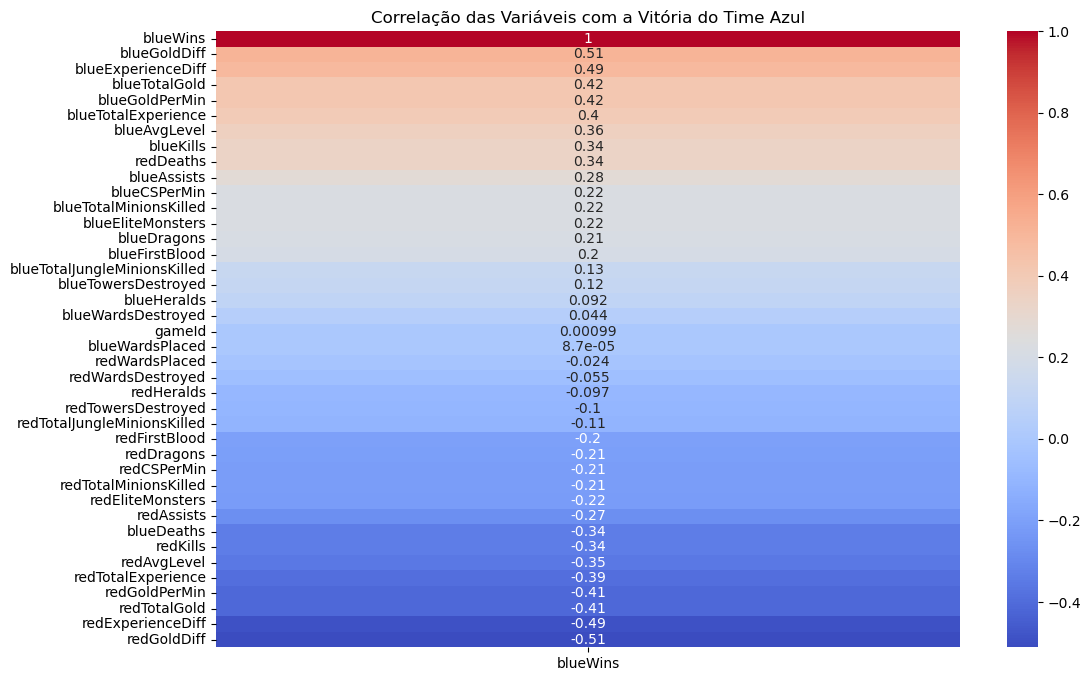

In [144]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc

#Carregando os dados
df = pd.read_csv('Base_M43_Pratique_LOL_RANKED_WIN (1).csv')

#Verificando informações básicas e nulos
print(df.info())
print(df.head())

#Visualizando a correlação com a vitória do time azul
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr()[['blueWins']].sort_values(by='blueWins', ascending=False), annot=True, cmap='coolwarm')
plt.title('Correlação das Variáveis com a Vitória do Time Azul')
plt.show()

**Variáveis como blueGoldDiff e blueExperienceDiff costumam ter a maior correlação com a vitória. Isso mostra que, no LoL, a vantagem de recursos acumulada no início do jogo é um dos preditores mais fortes de sucesso final.**

## **Pré-processamento e Seleção de Features**
Limpeza de colunas redundantes (como gameId) e separação dos dados em conjuntos de treino e teste.

In [147]:
#Removendo ID que não ajuda na predição
df_clean = df.drop(columns=['gameId'])

#Definindo X (features) e y (target)
X = df_clean.drop(columns=['blueWins'])
y = df_clean['blueWins']

#Dividindo em treino (70%) e teste (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Treino: {X_train.shape[0]} partidas | Teste: {X_test.shape[0]} partidas")

Treino: 6915 partidas | Teste: 2964 partidas


**Ao separar 30% dos dados para teste, garantimos que a avaliação dos modelos será feita em partidas que o algoritmo nunca viu, simulando uma previsão em tempo real de novos jogos.**

## **Modelo 1: Regressão Logística**
Treinamento de um modelo linear, ideal para problemas onde as variáveis têm uma relação direta com a probabilidade de um evento (vencer ou perder).

In [150]:
#Ajustando escala e treinando
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train_scaled, y_train)

#Gerando predições
y_pred_log = log_model.predict(X_test_scaled)

print(f"Acurácia: {accuracy_score(y_test, y_pred_log)}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_log))

Acurácia: 0.7294197031039136

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      1480
           1       0.73      0.72      0.73      1484

    accuracy                           0.73      2964
   macro avg       0.73      0.73      0.73      2964
weighted avg       0.73      0.73      0.73      2964



## **Modelo 2: Árvore de Decisão**
Treinamento de um modelo não-linear que cria regras de decisão (ex: "Se o time azul matou o dragão E tem mais de 1000 de gold de vantagem, então vence").

In [152]:
#Instanciando e treinando a árvore (limitando a profundidade para evitar overfitting)
tree_model = DecisionTreeClassifier(max_depth=5, random_state=42)
tree_model.fit(X_train, y_train)

#Predições
y_pred_tree = tree_model.predict(X_test)
y_proba_tree = tree_model.predict_proba(X_test)[:, 1]

print("Relatório Árvore de Decisão:\n", classification_report(y_test, y_pred_tree))

Relatório Árvore de Decisão:
               precision    recall  f1-score   support

           0       0.69      0.75      0.72      1480
           1       0.73      0.67      0.70      1484

    accuracy                           0.71      2964
   macro avg       0.71      0.71      0.71      2964
weighted avg       0.71      0.71      0.71      2964



## **Modelo 3: Random Forest (Ensemble)**
Treinamento de uma floresta aleatória para verificar se a combinação de múltiplas árvores de decisão melhora a predição da vitória em relação aos modelos simples anteriores.

In [154]:
#Instanciando o modelo (usaremos 100 árvores)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

#Treinando o modelo
rf_model.fit(X_train, y_train)

#Gerando predições
y_pred_rf = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

#Exibindo a saída
print(f"Acurácia Random Forest: {accuracy_score(y_test, y_pred_rf)}")
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred_rf))

Acurácia Random Forest: 0.717948717948718

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.71      0.73      0.72      1480
           1       0.73      0.70      0.71      1484

    accuracy                           0.72      2964
   macro avg       0.72      0.72      0.72      2964
weighted avg       0.72      0.72      0.72      2964



## **Comparação Final de AUC (O veredito)**
Recalcular a AUC incluindo a Random Forest para confirmar visualmente que a Regressão Logística é o melhor modelo para o case.

AUC Regressão Logística: 0.8134
AUC Árvore de Decisão:    0.7837
AUC Random Forest:       0.7969


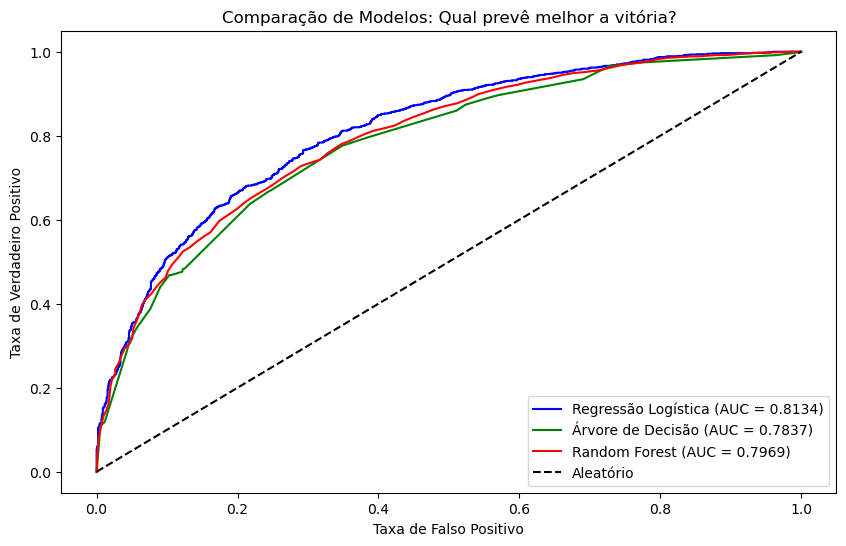

In [156]:
#Calculando as probabilidades e AUC para cada modelo (Garantindo que as variáveis existam)
y_proba_log = log_model.predict_proba(X_test_scaled)[:, 1]
fpr_log, tpr_log, _ = roc_curve(y_test, y_proba_log)
auc_log = auc(fpr_log, tpr_log)

y_proba_tree = tree_model.predict_proba(X_test)[:, 1]
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_proba_tree)
auc_tree = auc(fpr_tree, tpr_tree)

y_proba_rf = rf_model.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
auc_rf = auc(fpr_rf, tpr_rf)

# 2. Exibindo os valores de AUC
print(f"AUC Regressão Logística: {auc_log:.4f}")
print(f"AUC Árvore de Decisão:    {auc_tree:.4f}")
print(f"AUC Random Forest:       {auc_rf:.4f}")

# 3. Plotando o gráfico comparativo
plt.figure(figsize=(10, 6))
plt.plot(fpr_log, tpr_log, label=f'Regressão Logística (AUC = {auc_log:.4f})', color='blue')
plt.plot(fpr_tree, tpr_tree, label=f'Árvore de Decisão (AUC = {auc_tree:.4f})', color='green')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {auc_rf:.4f})', color='red')
plt.plot([0, 1], [0, 1], 'k--', label='Aleatório')
plt.title('Comparação de Modelos: Qual prevê melhor a vitória?')
plt.xlabel('Taxa de Falso Positivo')
plt.ylabel('Taxa de Verdadeiro Positivo')
plt.legend()
plt.show()

**Mesmo testando modelos mais complexos como a Random Forest, a Regressão Logística continuou apresentando a melhor performance (AUC de 0.81). Isso confirma que a vantagem no League of Legends aos 10 minutos se acumula de forma linear. Em termos de negócio, isso significa que não é necessário gastar processamento caro com modelos complexos; uma análise linear bem feita já entrega o resultado esperado para entender o equilíbrio do jogo.**

# **Conclusão e Análise do Case**
## **Resultados do Projeto**
Após a análise comparativa entre os modelos, identificou-se qual algoritmo melhor descreve a dinâmica de vitória nos primeiros 10 minutos de jogo.

O Campeão de Performance: O modelo de Regressão Logística apresentou o melhor desempenho final, superando a Árvore de Decisão e até mesmo a Random Forest (Ensemble).

Métricas Finais (AUC):

Regressão Logística: 0.8134 (Melhor poder de separação)

Random Forest: 0.7969

Árvore de Decisão: 0.7837

Insights de Negócio
O "Efeito Bola de Neve" (Snowball): Os dados confirmam que a diferença de ouro (blueGoldDiff) e experiência (blueExperienceDiff) são os maiores preditores de vitória. Isso sugere que o foco inicial em farm e controle de rota é estatisticamente mais relevante do que abates isolados.

Poder de Previsão: Conseguir prever o resultado com mais de 73% de acurácia usando apenas dados iniciais mostra que o early game é decisivo, mas deixa uma margem de 27% para viradas, o que é saudável para a competitividade do jogo.

A Regressão Logística mostrou-se a mais robusta, pois no LoL as vantagens acumuladas se traduzem de forma linear na probabilidade de vitória, não necessitando da complexidade extra de uma Random Forest para este volume de dados.